# DENOISING DIFFUSION IMPLICIT MODELS

## Imports

In [35]:
import datetime
from tensorflow.keras import (
    utils
)
import tensorflow as tf
import matplotlib.pyplot as plt
import math

## Global Settings

In [6]:
flowers_path='./datasets/flowers/'
log_dir= './logs/ddim/flowers/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

## Functions

In [42]:
def preprocess_flowers(img):
    img= tf.cast(img,'float32') / 255.0
    return img

def sample_batch(dataset):
    batch= dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch= batch[0]

    return batch.numpy()

def display_sample(images, n=10, size=(20,3), cmap='gray_r', as_type='float32'):
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images= (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _= plt.subplot(1,n,i+1) # (n, 1, i + 1) Arrange as n rows and 1 column
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis('off')

    plt.show()

def linear_diffusion_schedule(diffusion_times):
    min_rate= 1e-4
    max_rate= .02
    betas= min_rate + diffusion_times * (max_rate - min_rate)
    alphas= 1- betas
    alphas_bar= tf.math.cumprod(alphas)
    
    signal_rates= tf.sqrt(alphas_bar)
    noise_rates= tf.sqrt(1 - alphas_bar)

    return noise_rates, signal_rates

def cosine_diffusion_schedule(diffusion_times):
    signal_rates= tf.cos(diffusion_times * math.pi /2)
    noise_rates= tf.sin(diffusion_times * math.pi /2)

    return noise_rates, signal_rates

def offset_cos_diffusion_schedule(diffusion_times):
    min_signal_rate= .02
    max_signal_rate= .95
    start_angle= tf.acos(max_signal_rate)
    end_angle= tf.acos(min_signal_rate)
    diffusion_angles= start_angle + diffusion_times * (end_angle - start_angle)

    signal_rates= tf.cos(diffusion_angles)
    noise_rates= tf.sin(diffusion_angles)

    return noise_rates, signal_rates

## INIT DATASET

### Load data

In [19]:
%%time
# ~ 20 sec.
train_data= utils.image_dataset_from_directory(
    flowers_path + 'dataset/all_in_one',
    labels=None,
    image_size=(64,64),
    batch_size=None,
    shuffle=True,
    seed=42,
    interpolation='bilinear'
)

Found 8189 files.
CPU times: user 235 ms, sys: 866 ms, total: 1.1 s
Wall time: 20.6 s


### Configure dataset

In [21]:
%%time
# ~ 17ms
train= train_data.map(lambda x: preprocess_flowers(x))
train= train.repeat(5)
train= train.batch(64, drop_remainder=True)

Cause: could not parse the source code of <function <lambda> at 0x7f00fc6bf420>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f00fc6bf420>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 17.6 ms


### Samplying

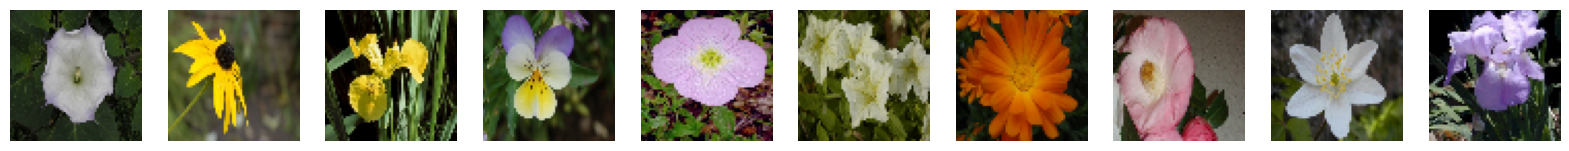

In [29]:
train_sample= sample_batch(train)
display_sample(train_sample)

## DIFFUSION SCHEDULES

In [43]:
T=1000
diffusion_times= tf.convert_to_tensor([x / T for x in range(T)])

(
    linear_noise_rates, 
    linear_signal_rates
)= linear_diffusion_schedule(diffusion_times)

(
    cosine_noise_rates, 
    cosine_signal_rates
)= cosine_diffusion_schedule(diffusion_times)

(
    offset_cos_noise_rates, 
    offset_cos_signal_rates
) = offset_cos_diffusion_schedule(diffusion_times)    
    

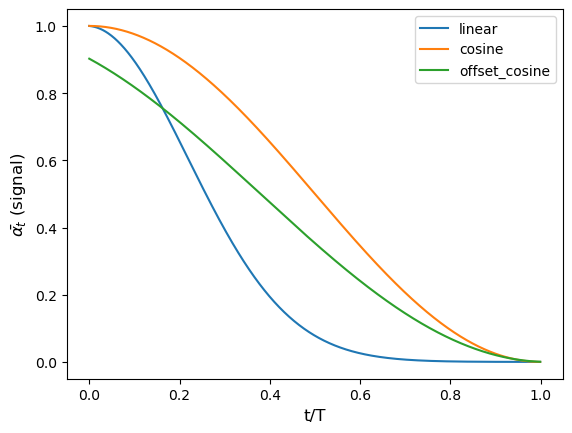

In [47]:
plt.plot(
    diffusion_times,
    linear_signal_rates**2,
    linewidth=1.5,
    label='linear'
)

plt.plot(
    diffusion_times,
    cosine_signal_rates**2,
    linewidth=1.5,
    label='cosine'
)

plt.plot(
    diffusion_times,
    offset_cos_signal_rates**2,
    linewidth=1.5,
    label='offset_cosine'
)

plt.xlabel("t/T",fontsize=12)
plt.ylabel(r"$\bar{\alpha_t}$ (signal)", fontsize=12)
plt.legend()
plt.show()

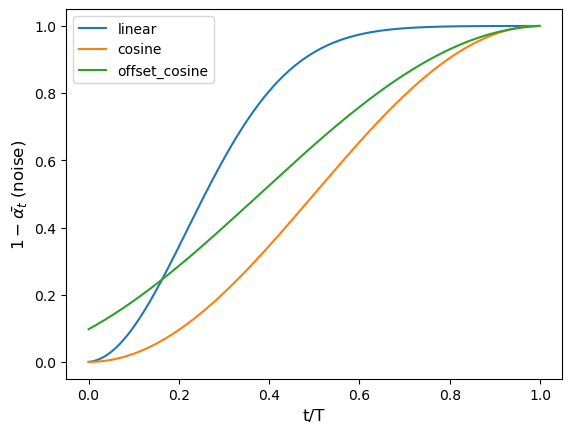

In [49]:
plt.plot(diffusion_times, linear_noise_rates**2,linewidth=1.5, label='linear')
plt.plot(diffusion_times, cosine_noise_rates**2,linewidth=1.5, label='cosine')
plt.plot(diffusion_times, offset_cos_noise_rates**2, linewidth=1.5, label='offset_cosine')

plt.xlabel('t/T', fontsize=12)
plt.ylabel(r'$1-\bar{\alpha_t}$ (noise)', fontsize=12)
plt.legend()
plt.show()

## BUILD MODEL